# LGBM Model 

In [1]:
import pandas as pd 
import numpy as np 

## Setting Up the Data 

In [2]:
df = pd.read_csv('modeling_data.csv')
drops = ['LS_PO_WINS','LS_CONF_RANK','MADE_PLAYOFFS']
df.drop(drops,axis=1,inplace=True)
print(df.shape)
df.head()

(687, 17)


,TEAM_SEASON,LS_MIN,LS_EFG_PCT,LS_FTA_RATE,LS_TM_TOV_PCT,LS_OREB_PCT,LS_OPP_EFG_PCT,LS_OPP_FTA_RATE,LS_OPP_TOV_PCT,LS_OPP_OREB_PCT,HEIGHT_INCHES,WEIGHT,EXP,LS_WIN_PCT,PO_WINS,TEAM_ID,TEAM_NAME
0,1610612737_2001-02,18.097566,0.461098,0.324734,0.163691,0.266759,0.476202,0.355158,0.153661,0.286407,80.000000,224.615385,3.153846,0.305,0.0,1610612737,Hawks
1,1610612737_2002-03,17.691622,0.459190,0.296291,0.165052,0.252703,0.490334,0.332949,0.151786,0.301969,79.187500,224.562500,4.125000,0.402,0.0,1610612737,Hawks
2,1610612737_2003-04,16.653165,0.467314,0.320842,0.167814,0.275845,0.480911,0.323210,0.142232,0.289654,80.133333,227.000000,4.000000,0.427,0.0,1610612737,Hawks
3,1610612737_2004-05,13.812289,0.432378,0.324171,0.166552,0.250593,0.494104,0.375538,0.167617,0.286726,79.769231,225.923077,5.076923,0.341,0.0,1610612737,Hawks
4,1610612737_2005-06,21.489895,0.463531,0.327702,0.170385,0.274347,0.510406,0.369320,0.144927,0.280918,78.846154,223.615385,1.923077,0.159,0.0,1610612737,Hawks


In [3]:
def modeling_data_setup(data,test_seasons,this_season,model_type):
    # returns x, xtest, y, ytest, this season's data 
    
    target = 'PO_WINS'
    
    import pandas as pd
    import numpy as np 
    
    if type(test_seasons) == int:
        test_seasons = [test_seasons]
    elif type(test_seasons) == list:
        test_seasons = test_seasons
    else:
        raise TypeError("ERROR! Please enter the test_seasons as type int or list (of int)")
        
    for i in test_seasons:
        if type(i)!=int:
            raise TypeError("ERROR! Please enter the test_seasons as type int or list (of int)")
    
    import pandas as pd
    import numpy as np 
    from sklearn.model_selection import train_test_split
    
    print('columns to drop:')
    drop_cols = ['TEAM_SEASON','TEAM_ID','TEAM_NAME','PO_WINS','SEASON']
    print(drop_cols)
    
    print('Creating SEASON for splitting')
    ids = data['TEAM_SEASON'].str.split('_')
    season = [int(x[1][0:4]) for x in ids]
    data['SEASON'] = season
    
    print("Dropping this season: {}".format(this_season))
    current = data[data['SEASON']==this_season].copy()
    
    print('Dropping the Pelicans and Hornets first season')
    data = data[~data['LS_WIN_PCT'].isna()].copy()
    
    test = data[data['SEASON'].isin(test_seasons)].copy()
    train = data[(~data['SEASON'].isin(test_seasons))&(data['SEASON']!=this_season)].copy()
    ytest = test[target].copy()
    ytrain = train[target].copy()
    xtest = test.drop(drop_cols,axis=1)
    xtrain = train.drop(drop_cols,axis=1)
    
    print("Returning: Train, Test, X Train, X Test, Y Train, Y Test, and the Upcoming Season")
    
    return train,test,xtrain,xtest,ytrain,ytest,current

In [4]:
train, test, x_train, x_test, y_train, y_test, upcoming = modeling_data_setup(df,[2022],2023,'reg')

columns to drop:
['TEAM_SEASON', 'TEAM_ID', 'TEAM_NAME', 'PO_WINS', 'SEASON']
Creating SEASON for splitting
Dropping this season: 2023
Dropping the Pelicans and Hornets first season
Returning: Train, Test, X Train, X Test, Y Train, Y Test, and the Upcoming Season


In [5]:
id_cols = ['TEAM_SEASON','TEAM_ID','TEAM_NAME','SEASON']
train_ids = train[id_cols].copy()
test_ids = test[id_cols].copy()

## Modeling

In [6]:
# basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# for feature reduction 
from sklearn import feature_selection
from sklearn import pipeline

# for the modeling
from lightgbm import LGBMClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

# from sklearn.externals import joblib
import time
import numpy as np

# getting rid of the warnings 
import warnings
warnings.filterwarnings('ignore')

def running_time(start):
    print('running time is', (time.time() - start)/60, 'mins')

In [7]:
start = time.time()

rds_params = {
'boosting_type': ['goss'],
'n_estimators':[1600],
'max_depth': [6,7,8], # over 6 
'subsample': [0.3],
'num_leaves': [15],
'subsample_for_bin': [5000],  #Change the subsample for bin 5000, 10,000, 20000
'colsample_bytree':[0.6,0.7,0.8],
'min_child_samples': [14,15,16], # around 15 
'min_child_weight': [14],
'lambda_l1': [4,5],
'learning_rate': [.015,0.02,.025], # around
'lambda_l2': [11,12,13,14,15], # around 12 - 14 
}

model = LGBMClassifier(n_jobs = -1)

clf = GridSearchCV(model, rds_params, cv=3, verbose=1,scoring = 'neg_root_mean_squared_error',return_train_score = True,n_jobs=-1)
clf.fit(x_train,y_train)

running_time(start)

Fitting 3 folds for each of 810 candidates, totalling 2430 fits
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l2 is set=11, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11
running time is 3.461150542894999 mins


In [8]:
cv = pd.DataFrame( clf.cv_results_)

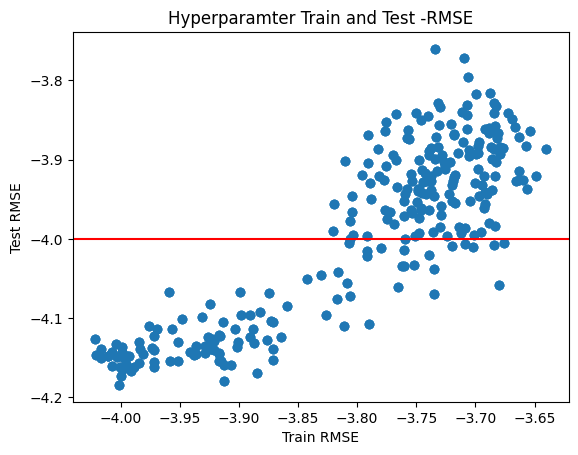

In [9]:
#Plotting the test and train gini to select best parameter
import matplotlib.pyplot as plt
plt.scatter(cv['mean_train_score'],cv['mean_test_score'] )
plt.axhline(-4, color='r', linestyle='-')
plt.xlabel('Train RMSE')
plt.ylabel('Test RMSE')
#for i in range(cv.shape[0]):
#    plt.text(x=cv['mean_train_score'][i],y=cv['mean_test_score'][i]+0.3,s=cv['rank_test_score'][i],fontdict=dict(size=5))
plt.title('Hyperparamter Train and Test -RMSE')
plt.show()

In [10]:
pd.set_option('display.max_columns',None)

In [11]:
cv[cv['mean_test_score']>-4]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_boosting_type,param_colsample_bytree,param_lambda_l1,param_lambda_l2,param_learning_rate,param_max_depth,param_min_child_samples,param_min_child_weight,param_n_estimators,param_num_leaves,param_subsample,param_subsample_for_bin,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
9,1.724382,0.017782,0.114166,0.020670,goss,0.6,4,11,0.02,6,14,14,1600,15,0.3,5000,"{'boosting_type': 'goss', 'colsample_bytree': ...",-4.244896,-3.655870,-3.889087,-3.929951,0.242199,295,-3.813249,-3.836590,-3.717223,-3.789021,0.051655
10,1.736425,0.037457,0.168922,0.048048,goss,0.6,4,11,0.02,6,15,14,1600,15,0.3,5000,"{'boosting_type': 'goss', 'colsample_bytree': ...",-4.150863,-3.663752,-3.962565,-3.925727,0.200561,268,-3.630136,-3.702031,-3.657717,-3.663295,0.029615
11,1.744969,0.026188,0.228264,0.050258,goss,0.6,4,11,0.02,6,16,14,1600,15,0.3,5000,"{'boosting_type': 'goss', 'colsample_bytree': ...",-4.150863,-3.568020,-3.989771,-3.902885,0.245748,205,-3.640055,-3.817792,-3.721092,-3.726313,0.072655
12,1.724572,0.020012,0.201981,0.062445,goss,0.6,4,11,0.02,7,14,14,1600,15,0.3,5000,"{'boosting_type': 'goss', 'colsample_bytree': ...",-4.244896,-3.655870,-3.889087,-3.929951,0.242199,295,-3.813249,-3.836590,-3.717223,-3.789021,0.051655
13,1.711202,0.006347,0.284864,0.082964,goss,0.6,4,11,0.02,7,15,14,1600,15,0.3,5000,"{'boosting_type': 'goss', 'colsample_bytree': ...",-4.150863,-3.663752,-3.962565,-3.925727,0.200561,268,-3.630136,-3.702031,-3.657717,-3.663295,0.029615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,1.713183,0.025380,0.090058,0.014971,goss,0.8,5,15,0.025,7,15,14,1600,15,0.3,5000,"{'boosting_type': 'goss', 'colsample_bytree': ...",-3.913539,-3.555873,-3.846202,-3.771871,0.155188,4,-3.618861,-3.809303,-3.699763,-3.709309,0.078040
806,1.669255,0.010915,0.100235,0.032136,goss,0.8,5,15,0.025,7,16,14,1600,15,0.3,5000,"{'boosting_type': 'goss', 'colsample_bytree': ...",-3.942772,-3.816084,-3.876085,-3.878314,0.051744,124,-3.576096,-3.841275,-3.672439,-3.696603,0.109599
807,1.696760,0.038086,0.122311,0.033988,goss,0.8,5,15,0.025,8,14,14,1600,15,0.3,5000,"{'boosting_type': 'goss', 'colsample_bytree': ...",-3.968175,-3.699012,-3.984344,-3.883844,0.130862,133,-3.551814,-3.812135,-3.672439,-3.678796,0.106371
808,1.641418,0.005702,0.093850,0.019284,goss,0.8,5,15,0.025,8,15,14,1600,15,0.3,5000,"{'boosting_type': 'goss', 'colsample_bytree': ...",-3.913539,-3.555873,-3.846202,-3.771871,0.155188,4,-3.618861,-3.809303,-3.699763,-3.709309,0.078040


In [12]:
cvp = cv[['param_subsample_for_bin','param_subsample','param_num_leaves','param_n_estimators','param_min_child_weight','param_min_child_samples','param_max_depth','param_learning_rate','param_lambda_l2','param_lambda_l1','param_colsample_bytree','mean_test_score']]

In [14]:
import seaborn as sns 
import matplotlib.pyplot as plt

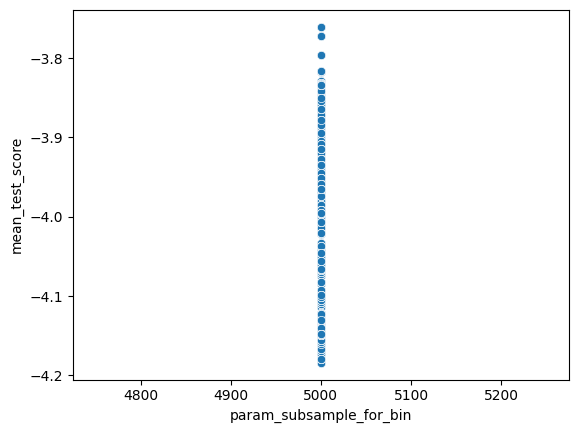

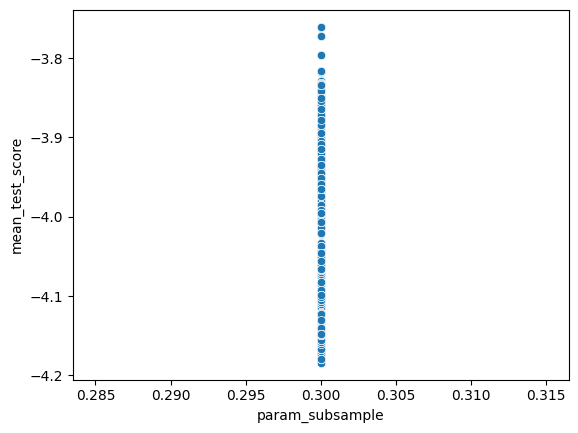

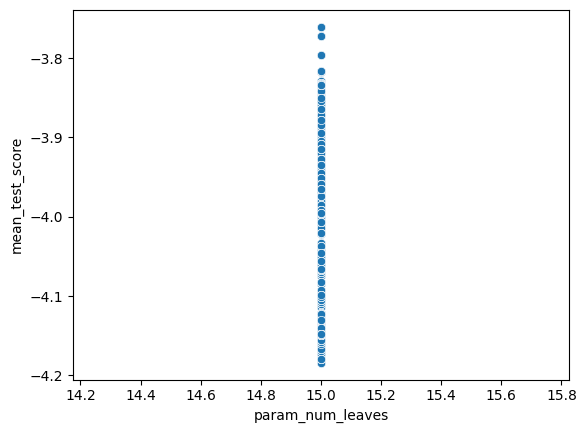

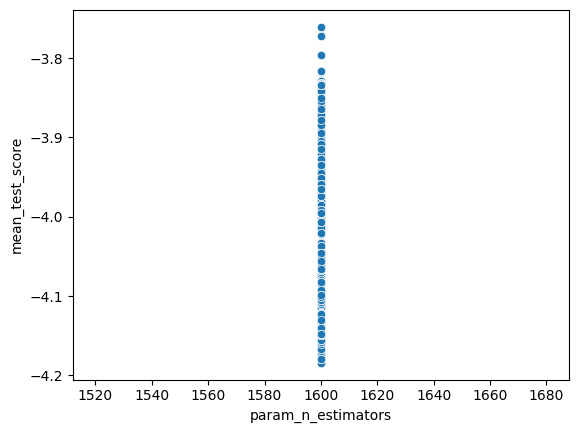

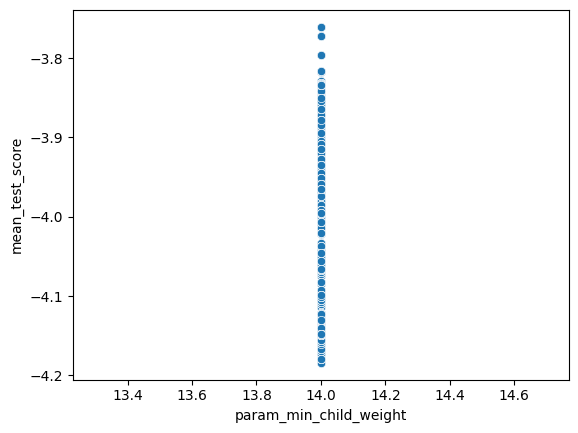

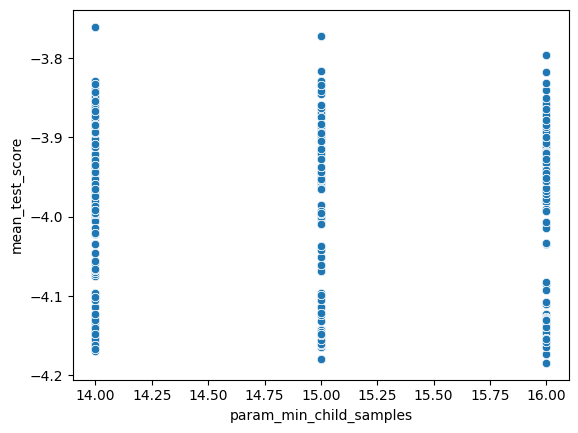

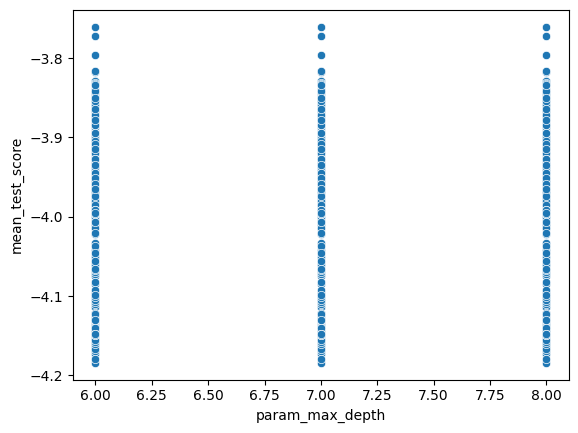

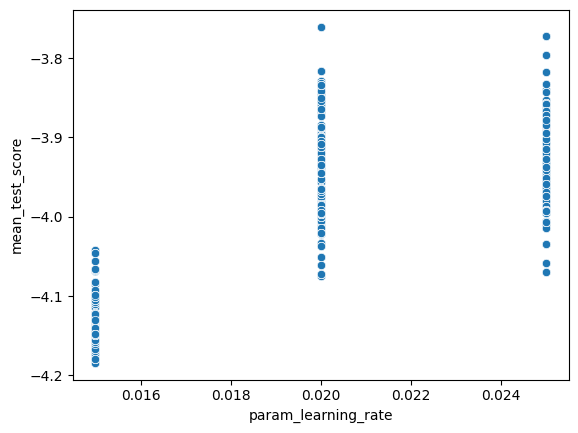

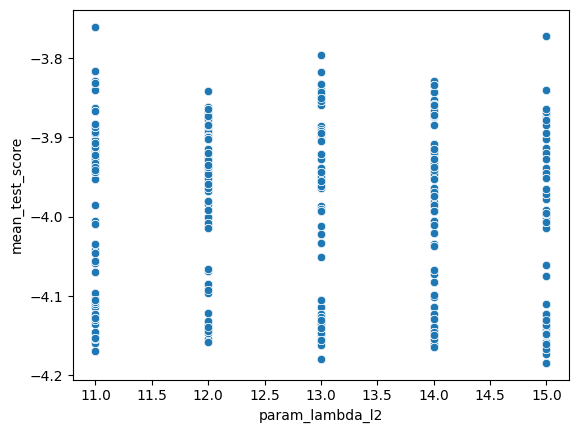

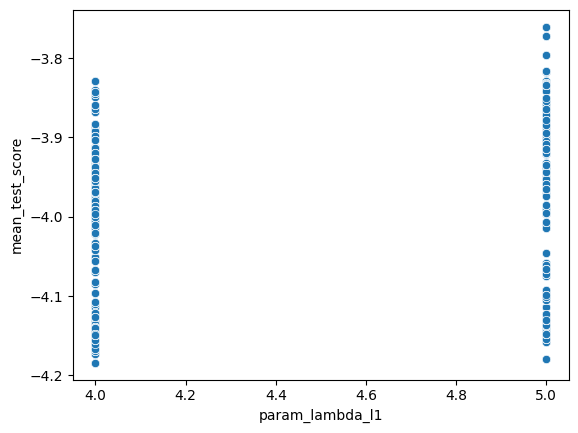

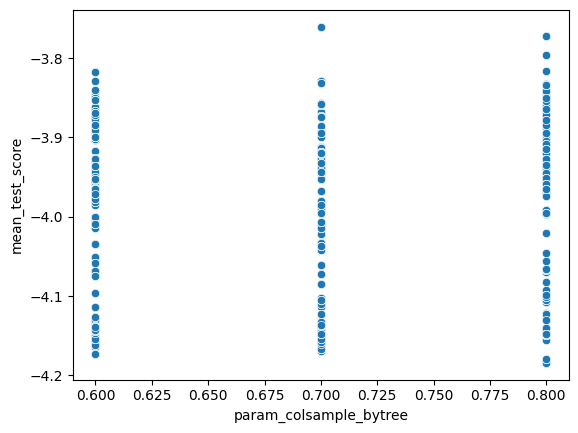

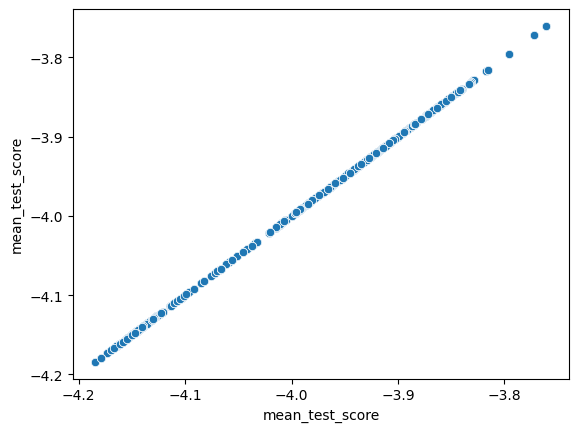

In [15]:
for i in cvp.columns:
    sns.scatterplot(data=cvp,x=i,y='mean_test_score')
    plt.show()

In [46]:
#tp - can delete if doesnt work out 
model = LGBMClassifier(n_jobs = -1)
params = cv.head(2).iloc[1,16]
params

{'boosting_type': 'goss',
 'colsample_bytree': 0.6,
 'lambda_l1': 4,
 'lambda_l2': 11,
 'learning_rate': 0.015,
 'max_depth': 6,
 'min_child_samples': 15,
 'min_child_weight': 14,
 'n_estimators': 1600,
 'num_leaves': 15,
 'subsample': 0.3,
 'subsample_for_bin': 5000}

In [48]:
params = {'boosting_type': ['goss'],
 'colsample_bytree': [0.6],
 'lambda_l1': [4],
 'lambda_l2': [11],
 'learning_rate': [0.015],
 'max_depth': [6],
 'min_child_samples': [15],
 'min_child_weight': [14],
 'n_estimators': [1600],
 'num_leaves': [15],
 'subsample': [0.3],
 'subsample_for_bin': [5000]}

In [49]:
clf = GridSearchCV(model, params, cv=3, verbose=1,scoring = 'neg_root_mean_squared_error',return_train_score = True,n_jobs=-1)
clf.fit(x_train,y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4
[LightGBM] [Warning] lambda_l2 is set=11, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11


GridSearchCV(cv=3, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'boosting_type': ['goss'], 'colsample_bytree': [0.6],
                         'lambda_l1': [4], 'lambda_l2': [11],
                         'learning_rate': [0.015], 'max_depth': [6],
                         'min_child_samples': [15], 'min_child_weight': [14],
                         'n_estimators': [1600], 'num_leaves': [15],
                         'subsample': [0.3], 'subsample_for_bin': [5000]},
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=1)

## Evaluation

In [50]:
import sklearn

### Train 

In [51]:
predictions = clf.predict(x_train)

In [52]:
mse = sklearn.metrics.mean_squared_error(y_train,predictions)
mae = sklearn.metrics.mean_absolute_error(y_train,predictions)
r2 = sklearn.metrics.r2_score(y_train,predictions)
rmse = np.sqrt(mse)

In [53]:
train_output = pd.DataFrame({'Actual':y_train,'Prediction':predictions})
train_output['Team'] = train['TEAM_NAME']
train_output['Season'] = train['SEASON']
train_output.sort_values(['Season','Prediction'],inplace=True)
metrics_list = ['MSE','MAE','R2','RMSE']
values = [mse,mae,r2,rmse]
train_results = pd.DataFrame({'METRIC':metrics_list,'VALUE':values})
train_results = train_results.transpose().reset_index(drop=True)
train_results.columns = train_results.iloc[0,:]
train_results = train_results.tail(1)

In [54]:
train_output.head()

,Actual,Prediction,Team,Season
0,0.0,0.0,Hawks,2001
46,0.0,0.0,Cavaliers,2001
91,0.0,0.0,Bulls,2001
137,0.0,0.0,Nuggets,2001
160,0.0,0.0,Warriors,2001


In [55]:
train_results

,MSE,MAE,R2,RMSE
1,24.4976,3.1888,-0.311638,4.949505


### Test 

In [56]:
predictions = clf.predict(x_test)

In [57]:
mse = sklearn.metrics.mean_squared_error(y_test,predictions)
mae = sklearn.metrics.mean_absolute_error(y_test,predictions)
r2 = sklearn.metrics.r2_score(y_test,predictions)
rmse = np.sqrt(mse)

In [58]:
test_output = pd.DataFrame({'Actual':y_test,'Prediction':predictions})
test_output['Team'] = test['TEAM_NAME']
test_output['Season'] = test['SEASON']
test_output.sort_values(['Season','Prediction'],inplace=True)
metrics_list = ['MSE','MAE','R2','RMSE']
values = [mse,mae,r2,rmse]
test_results = pd.DataFrame({'METRIC':metrics_list,'VALUE':values})
test_results = test_results.transpose().reset_index(drop=True)
test_results.columns = test_results.iloc[0,:]
test_results = test_results.tail(1)

In [59]:
test_output.head()

,Actual,Prediction,Team,Season
21,2.0,0.0,Hawks,2022
89,0.0,0.0,Pelicans,2022
204,0.0,0.0,Rockets,2022
227,1.0,0.0,Clippers,2022
250,8.0,0.0,Lakers,2022


In [60]:
test_results

,MSE,MAE,R2,RMSE
1,19.366667,3.1,-0.051013,4.400758


### Upcoming Season 

In [61]:
x_up = upcoming[clf.best_estimator_.feature_name_]
x_up.head()

,LS_MIN,LS_EFG_PCT,LS_FTA_RATE,LS_TM_TOV_PCT,LS_OREB_PCT,LS_OPP_EFG_PCT,LS_OPP_FTA_RATE,LS_OPP_TOV_PCT,LS_OPP_OREB_PCT,HEIGHT_INCHES,WEIGHT,EXP,LS_WIN_PCT
22,18.016026,0.545016,0.266234,0.138654,0.244933,0.546807,0.273492,0.132161,0.228750,74.210526,212.500000,4.210526,0.500
45,17.141471,0.574906,0.245406,0.154088,0.205274,0.551555,0.261706,0.134655,0.210411,79.235294,221.470588,5.352941,0.695
68,18.456579,0.533045,0.246079,0.154702,0.218635,0.528808,0.282211,0.151173,0.226084,77.894737,211.263158,5.000000,0.622
90,19.033183,0.531229,0.300521,0.136806,0.241501,0.540870,0.260355,0.134875,0.219382,78.500000,215.875000,4.375000,0.512
113,20.332340,0.553620,0.264355,0.128804,0.215955,0.533605,0.257386,0.150217,0.204654,78.000000,214.150000,4.650000,0.488


In [62]:
predictions = clf.predict(x_up)
final_output = x_up.copy() 
final_output['Predicted Wins'] = predictions
final_output['Predicted Wins (Rounded)'] = [round(x) for x in predictions]
final_output['Team'] = upcoming['TEAM_NAME']
def rounds(x):
    if x < 4:
        return 'R1/Lottery'
    elif 4<=x<8:
        return 'Second Round'
    elif 8<=x<12: 
        return 'Conf. Finals'
    elif 12<=x<16:
        return 'Finals'
    elif x>=16:
        return 'Champions'
final_output['Round'] = [rounds(x) for x in final_output['Predicted Wins']]
final_output.sort_values('Predicted Wins',inplace=True)
fo = final_output[['Team','Predicted Wins','Predicted Wins (Rounded)','Round']]
fo

,Team,Predicted Wins,Predicted Wins (Rounded),Round
343,Nets,0.0,0,R1/Lottery
642,Wizards,0.0,0,R1/Lottery
596,Jazz,0.0,0,R1/Lottery
550,Thunder,0.0,0,R1/Lottery
527,Spurs,0.0,0,R1/Lottery
481,Trail Blazers,0.0,0,R1/Lottery
412,Pacers,0.0,0,R1/Lottery
389,Magic,0.0,0,R1/Lottery
665,Pistons,0.0,0,R1/Lottery
686,Hornets,0.0,0,R1/Lottery


In [63]:
len(list(final_output['Team']))

30

In [64]:
ec_teams = ['Hornets',
 'Wizards',
 'Hawks',
 'Pacers',
 'Magic',
 'Pistons',
 'Raptors',
 'Knicks',
 'Bulls',
 'Cavaliers',
 'Nets',
 '76ers',
 'Heat',
 'Celtics',
 'Bucks']
wc_teams = ['Thunder',
 'Rockets',
 'Spurs',
 'Trail Blazers',
 'Kings',
 'Pelicans',
 'Grizzlies',
 'Timberwolves',
 'Jazz',
 'Warriors',
 'Mavericks',
 'Lakers',
 'Clippers',
 'Suns',
 'Nuggets']

In [65]:
ec = fo[fo['Team'].isin(ec_teams)]
wc = fo[fo['Team'].isin(wc_teams)]

In [66]:
print("Bet to Win EC: ")
ecb = ec.sort_values('Predicted Wins').tail(4)
ecb

Bet to Win EC: 


,Team,Predicted Wins,Predicted Wins (Rounded),Round
366,Knicks,7.0,7,Second Round
274,Heat,7.0,7,Second Round
22,Hawks,7.0,7,Second Round
297,Bucks,16.0,16,Champions


In [67]:
print("Bet to Win WC: ")
wcb = wc.sort_values('Predicted Wins').tail(4)
wcb

Bet to Win WC: 


,Team,Predicted Wins,Predicted Wins (Rounded),Round
159,Nuggets,7.0,7,Second Round
182,Warriors,7.0,7,Second Round
320,Timberwolves,7.0,7,Second Round
228,Clippers,7.0,7,Second Round


In [68]:
print("Bet to Win NBA Finals: ")
fob = fo.sort_values('Predicted Wins').tail(4)
fob

Bet to Win NBA Finals: 


,Team,Predicted Wins,Predicted Wins (Rounded),Round
22,Hawks,7.0,7,Second Round
251,Lakers,7.0,7,Second Round
458,Suns,7.0,7,Second Round
297,Bucks,16.0,16,Champions


## Writing Info 

In [69]:
train_output['SUBSET'] = 'TRAIN'
test_output['SUBSET'] = 'TEST'
total_output = pd.concat([train_output,test_output])

In [70]:
train_results['SUBSET'] = 'TRAIN'
test_results['SUBSET'] = 'TEST'
total_results = pd.concat([train_results,test_results])
total_results

,MSE,MAE,R2,RMSE,SUBSET
1,24.4976,3.1888,-0.311638,4.949505,TRAIN
1,19.366667,3.1,-0.051013,4.400758,TEST


In [71]:
model_name = input()

2


In [72]:
initial_path = ''
cv_path = initial_path+model_name+'_cv_results.csv'
output_path = initial_path+model_name+'_output.csv'
results_path = initial_path+model_name+'_results.csv'
predictions_path = initial_path+model_name+'_full_predictions.csv'
ec_path = initial_path+model_name+'_ecf_predictions.csv'
wc_path = initial_path+model_name+'_wcf_predictions.csv'
f_path = initial_path+model_name+'_finals_predictions.csv'
print(cv_path)
print(output_path)
print(results_path)
print(predictions_path)
print(ec_path)
print(wc_path)
print(f_path)

2_cv_results.csv
2_output.csv
2_results.csv
2_full_predictions.csv
2_ecf_predictions.csv
2_wcf_predictions.csv
2_finals_predictions.csv


In [73]:
cv.to_csv(cv_path,index=False)
total_output.to_csv(output_path,index=False)
total_results.to_csv(results_path,index=False)
fo.to_csv(predictions_path,index=False)
ecb.to_csv(ec_path,index=False)
wcb.to_csv(wc_path,index=False)
fob.to_csv(f_path,index=False)

In [74]:
import pickle

# save the model to disk
filename = model_name+'.sav'
pickle.dump(clf, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

## What if I had Used this Model Last Year? 

In [75]:
ec2 = test_output[test_output['Team'].isin(ec_teams)]
wc2 = test_output[test_output['Team'].isin(wc_teams)]

In [76]:
print("Bet to Win EC: ")
ecb2 = ec2.sort_values('Prediction').tail(4)
ecb2

Bet to Win EC: 


,Actual,Prediction,Team,Season,SUBSET
296,1.0,7.0,Bucks,2022,TEST
434,7.0,7.0,76ers,2022,TEST
44,11.0,16.0,Celtics,2022,TEST
273,13.0,16.0,Heat,2022,TEST


In [77]:
print("Bet to Win WC: ")
wcb2 = wc2.sort_values('Prediction').tail(4)
wcb2

Bet to Win WC: 


,Actual,Prediction,Team,Season,SUBSET
319,1.0,7.0,Timberwolves,2022,TEST
595,0.0,7.0,Jazz,2022,TEST
158,16.0,16.0,Nuggets,2022,TEST
457,6.0,16.0,Suns,2022,TEST


In [78]:
print("Bet to Win NBA Finals: ")
fob2 = test_output.sort_values('Prediction').tail(4)
fob2

Bet to Win NBA Finals: 


,Actual,Prediction,Team,Season,SUBSET
273,13.0,16.0,Heat,2022,TEST
44,11.0,16.0,Celtics,2022,TEST
158,16.0,16.0,Nuggets,2022,TEST
457,6.0,16.0,Suns,2022,TEST
